In [2]:
import numpy as np
import pandas as pd
from keras.models import Sequential, Model
from keras.layers import LSTM, Dense, RepeatVector, TimeDistributed
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df_train = pd.read_csv('PSM/train.csv', usecols=lambda column: column not in ['timestamp_(min)'])
df_train = df_train.fillna(0)
df_train.shape

(132481, 25)

将时间序列数据转换为输入输出对.
- 对于异常检测任务，构建输入输出对可以帮助模型学会识别正常模式，当测试数据偏离这些正常模式时，可以识别出异常。
- 使用过去的正常数据作为输入，当前或未来数据作为输出，模型可以学习正常情况下的模式，当测试数据中出现异常时，模型可以检测出来。
- 对于每个时间步长，将过去的一段时间作为输入，当前或未来的时间步长作为输出

In [4]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1] #如果输入数据是列表，则变量数量为1；否则变量数量为数据的列数.25
    df = pd.DataFrame(data)
    cols, names = list(), list()
    #构建输入数据
    for i in range(n_in, 0, -1): 
        cols.append(df.shift(-i)) #生成过去的时间步长数据,将数据向前移动 -i 个时间步长，并将移动后的结果添加到 cols 列表中
        names += [('var%d(t+%d)' % (j + 1, i)) for j in range(n_vars)] #对于数据中的每列，创建一个包含变量编号和时间步长信息的字符串。
        #print(names)
    # forecast sequence (t, t+1, ... t+n)
    #构建输出数据
    for i in range(0, n_out): #生成未来的时间步长数据
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j + 1)) for j in range(n_vars)] #list,['var1(t+24)', 'var2(t+24)', 'var3(t+24)']
        else:
            names += [('var%d(t+%d)' % (j + 1, i)) for j in range(n_vars)]
        print(len(names))
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # 删除包含NAN的值
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [5]:
# 数据标准化
scaler = StandardScaler()
normal_data_scaled = scaler.fit_transform(df_train.values)


In [6]:
time_steps = 25  # 这个可调，可以调大一些，代表考虑的时间窗口

In [7]:
# 构造数据集
reframed = series_to_supervised(normal_data_scaled, time_steps-1, 1) #输入序列包含过去 24 个时间步长的数据。
print(reframed.head())
values = reframed.values
normal_data_scaled = values.reshape((values.shape[0], time_steps, -1)) #将数据重塑为 (样本数量, 时间步长, 特征数量) 的形状。
normal_data_scaled.shape

625
   var1(t+24)  var2(t+24)  var3(t+24)  var4(t+24)  var5(t+24)  var6(t+24)  \
0   -1.506442   -1.980378   -0.232504   -1.733080   -0.979290   -0.934770   
1   -1.505013   -1.984716   -0.225886   -1.733422   -0.972306   -1.044471   
2   -1.501492   -1.984077   -0.228296   -1.732984   -0.930405   -0.958277   
3   -1.499046   -1.982892   -0.242167   -1.733108   -0.937389   -1.122829   
4   -1.498548   -1.983854   -0.245274   -1.733219   -1.129436   -1.091486   

   var7(t+24)  var8(t+24)  var9(t+24)  var10(t+24)  ...  var16(t)  var17(t)  \
0   -0.252866    -1.23010   -0.835754    -0.902439  ... -1.906470 -1.279689   
1   -0.330423    -1.27175   -0.752694    -0.808272  ... -1.840368 -1.225496   
2   -0.097752    -1.23010   -0.721092    -0.747156  ... -1.201885 -1.218270   
3    0.290033    -1.29674   -0.812053    -0.860739  ... -0.837871 -1.169495   
4   -0.407980    -1.33839   -0.890820    -0.876644  ... -0.890830 -1.191173   

   var18(t)  var19(t)  var20(t)  var21(t)  var22(t)  var23

(132457, 25, 25)

在编码器-解码器模型中，输入和输出应该是相同的时间序列数据，目标是让模型学会重构输入序列。
- keras模型的输入是numpy数组，pytorch是张量torch

In [9]:
# 创建编码器-解码器模型 https://blog.csdn.net/weixin_35757704/article/details/118457110
model = Sequential()

# 编码器  # 这里的隐层神经元（32，16）可以改大一些，按照这种对称结构来改就行
model.add(LSTM(64, activation='relu', input_shape=(normal_data_scaled.shape[1], normal_data_scaled.shape[2]), return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=False)) 
model.add(RepeatVector(time_steps))

# 解码器
model.add(LSTM(64, activation='relu', return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=True)) #return_sequences=True 表示输出每个时间步的完整序列。
model.add(TimeDistributed(Dense(normal_data_scaled.shape[2]))) #Dense全连接
from keras.optimizers import Adam
# 编译模型
model.compile(optimizer=Adam(learning_rate=0.0001), loss='mse')

# 训练模型
history=model.fit(normal_data_scaled, normal_data_scaled, epochs=50, batch_size=256, shuffle=True, validation_split=0.1)   # 这里的epochs 越大越好, 可以暂定200. batch_size可以用128或者256试试
#第一个 normal_data_scaled 是作为模型的输入数据，用于训练模型。第二个 normal_data_scaled 是作为模型的目标输出数据（或标签数据），用于计算损失函数。

d:\anaconda\envs\anomaly\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
466/466 ━━━━━━━━━━━━━━━━━━━━ 43s 80ms/step - loss: 1.5876 - val_loss: 0.5923
Epoch 2/50
466/466 ━━━━━━━━━━━━━━━━━━━━ 32s 69ms/step - loss: 0.9189 - val_loss: 0.5143
Epoch 3/50
466/466 ━━━━━━━━━━━━━━━━━━━━ 32s 69ms/step - loss: 0.5756 - val_loss: 0.4676
Epoch 4/50
466/466 ━━━━━━━━━━━━━━━━━━━━ 32s 70ms/step - loss: 0.4601 - val_loss: 0.4217
Epoch 5/50
466/466 ━━━━━━━━━━━━━━━━━━━━ 32s 68ms/step - loss: 0.3728 - val_loss: 0.3845
Epoch 6/50
466/466 ━━━━━━━━━━━━━━━━━━━━ 31s 67ms/step - loss: 0.2948 - val_loss: 0.3574
Epoch 7/50
466/466 ━━━━━━━━━━━━━━━━━━━━ 31s 67ms/step - loss: 0.2450 - val_loss: 0.3320
Epoch 8/50
466/466 ━━━━━━━━━━━━━━━━━━━━ 31s 66ms/step - loss: 0.2168 - val_loss: 0.3114
Epoch 9/50
466/466 ━━━━━━━━━━━━━━━━━━━━ 32s 69ms/step - loss: 0.1960 - val_loss: 0.2977
Epoch 10/50
466/466 ━━━━━━━━━━━━━━━━━━━━ 33s 70ms/step - loss: 0.1761 - val_loss: 0.2776
Epoch 11/50
466/466 ━━━━━━━━━━━━━━━━━━━━ 32s 69ms/step - loss: 0.1652 - val_loss: 0.2575
Epoch 12/50
466/466 ━━━━━━━━━━

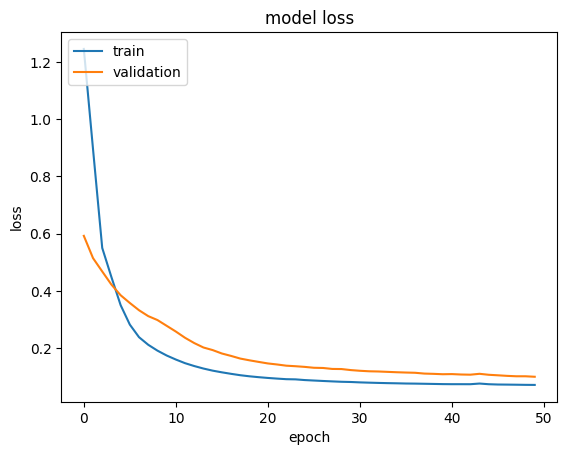

In [10]:
# loss的历史
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [11]:
df_test = pd.read_csv('PSM/test.csv', usecols=lambda column: column not in ['timestamp_(min)'])
df_test = df_test.fillna(0)
df_test.shape

(87841, 25)

In [12]:
test_data_scaled = scaler.fit_transform(df_test.values)

test_reframed = series_to_supervised(test_data_scaled, time_steps-1, 1)
test_values = test_reframed.values
test_data_scaled = test_values.reshape((test_values.shape[0], time_steps, -1))
test_data_scaled.shape

625


(87817, 25, 25)

$$MSE = \frac{1}{n} \sum_{i=1}^{n} (\hat{y}_i - y_i)^2$$


In [13]:
# 计算正常数据的均方误差MSE
reconstructed_normal_data = model.predict(normal_data_scaled)
mse_normal = np.mean(np.square(normal_data_scaled - reconstructed_normal_data), axis=(1, 2))

4140/4140 ━━━━━━━━━━━━━━━━━━━━ 30s 7ms/step


In [14]:
# 对异常数据集的重构误差计算
reconstructed_anomaly_data = model.predict(test_data_scaled)
mse_anomaly = np.mean(np.square(test_data_scaled - reconstructed_anomaly_data), axis=(1, 2))

2745/2745 ━━━━━━━━━━━━━━━━━━━━ 19s 7ms/step


In [19]:
test_label = pd.read_csv('PSM/test_label.csv')['label'].iloc[time_steps-1:]
pred_label = np.zeros(87842)

In [20]:
# threshold = np.mean(mse_normal)  # 设置阈值 可以自己调整，直接影响到精度值
threshold = np.mean(mse_normal) + 2 * np.std(mse_normal)
pred_label[mse_anomaly>threshold] = 1

IndexError: boolean index did not match indexed array along dimension 0; dimension is 87842 but corresponding boolean dimension is 87817

In [17]:
# 将预测标签转换为DataFrame
pred_df = pd.DataFrame(pred_label, columns=[ "label"])

# 将DataFrame写入CSV文件
pred_df.to_csv('pred_label_epoch50_batchsize256.csv', index=False)

In [21]:
test_label = pd.read_csv('PSM/test_label.csv')['label'].iloc[time_steps-1:]
pred_label = pd.read_csv('pred_label.csv')['label'].iloc[time_steps-1:]


# 评价指标
accuracy = accuracy_score(test_label, pred_label)
precision = precision_score(test_label, pred_label)
recall = recall_score(test_label, pred_label)
f1 = f1_score(test_label, pred_label)
roc_auc = roc_auc_score(test_label, pred_label)
conf_matrix = confusion_matrix(test_label, pred_label)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("ROC AUC Score:", roc_auc)
print("Confusion Matrix:")
print(conf_matrix)

Accuracy: 0.7905416946604872
Precision: 0.8934156919437508
Recall: 0.27882367417251136
F1 Score: 0.42500781494216944
ROC AUC Score: 0.6330195677123986
Confusion Matrix:
[[62625   811]
 [17583  6798]]


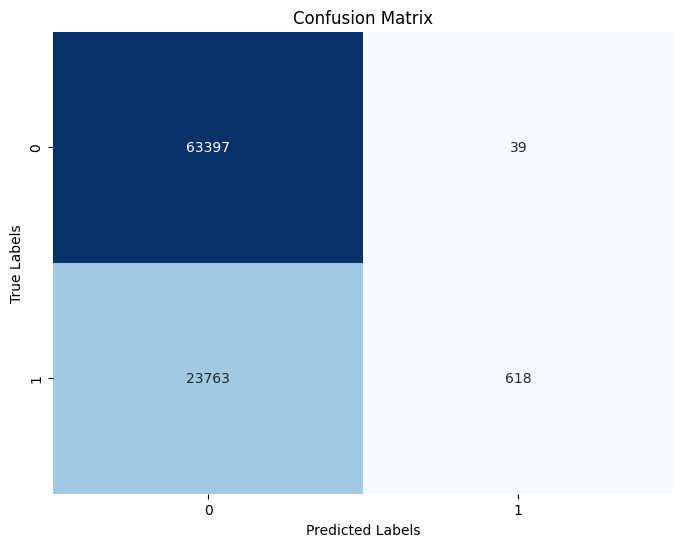

In [22]:
# 画混淆矩阵的热图
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

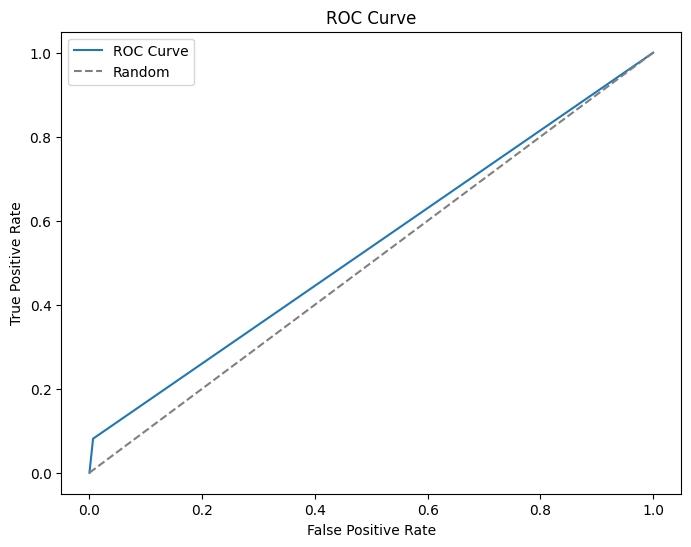

In [141]:
# 画ROC曲线
fpr, tpr, thresholds = roc_curve(test_label, pred_label)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC Curve')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()